# FastText

Dans ce notebook, on implémente le modèle **FastText** issu de l'article <a href="https://arxiv.org/pdf/1607.01759.pdf">Bag of Tricks for Efficient Text Classification</a> pour l'analyse de sentiments.

## Import et préparation des données




On définit une fonction qui génère des bigrames comme dans l'exemple ci-dessous.

In [1]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'is terrible', 'This film', 'film is']

On pré-traite les données comme précédemment en utilisant la fonction `generate_bigrams` comme paramètre de la méthode `Field`.

In [2]:
import torch
from torchtext import data
from torchtext import datasets
import random
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [3]:
import random
test_data, valid_data = test_data.split(random_state = random.seed(1234))

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


In [4]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,sort=False)

## Construire le modèle

Ce modèle a beaucoup moins de paramètres que le modèle précédent car il n'a que 2 couches qui ont des paramètres, la couche d'intégration et la couche linéaire. Il n'y a pas de composant RNN.

<center> <img src="img/fast.png" alt="drawing" width="300"/>
    
Au lieu de cela, il calcule d'abord le mot incorporé pour chaque mot à l'aide de l'embedding, puis calcule la moyenne de tous les mots incorporés et le transmet à travers la couche linéaire.

Nous implémentons le calcul de moyenne avec la fonction `avg_pool2d`. En effet, on peut considérer les mots incorporés comme une grille à 2 dimensions, où les mots sont le long d'un axe et les dimensions des mots incorporés le long de l'autre.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(self.dropout(pooled))

In [6]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
DROPOUT = 0.6

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX, DROPOUT)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 5,000,301 paramètres à entraîner


Ce modèle a deux fois moins de paramètres.

In [8]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Optimiseur et fonction de coût

In [9]:
import torch.optim as optim

def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

## Métrique

In [10]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

## Entraînement

In [11]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 100

best_valid_loss = float('inf')
tloss = []
tacc = []
vloss = []
vacc = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc)  
    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)  
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    if epoch%10 == 0:
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.693 | Train Acc: 50.22%
	 Val. Loss: 0.692 |  Val. Acc: 51.42%
Epoch: 11 | Epoch Time: 0m 19s
	Train Loss: 0.673 | Train Acc: 66.95%
	 Val. Loss: 0.672 |  Val. Acc: 69.47%
Epoch: 21 | Epoch Time: 0m 27s
	Train Loss: 0.624 | Train Acc: 72.65%
	 Val. Loss: 0.624 |  Val. Acc: 73.32%
Epoch: 31 | Epoch Time: 0m 29s
	Train Loss: 0.560 | Train Acc: 77.57%
	 Val. Loss: 0.563 |  Val. Acc: 77.20%
Epoch: 41 | Epoch Time: 0m 29s
	Train Loss: 0.494 | Train Acc: 81.73%
	 Val. Loss: 0.502 |  Val. Acc: 80.82%
Epoch: 51 | Epoch Time: 0m 29s
	Train Loss: 0.436 | Train Acc: 84.60%
	 Val. Loss: 0.449 |  Val. Acc: 83.09%
Epoch: 61 | Epoch Time: 0m 29s
	Train Loss: 0.388 | Train Acc: 86.29%
	 Val. Loss: 0.408 |  Val. Acc: 85.12%
Epoch: 71 | Epoch Time: 0m 29s
	Train Loss: 0.351 | Train Acc: 87.69%
	 Val. Loss: 0.378 |  Val. Acc: 86.13%
Epoch: 81 | Epoch Time: 0m 22s
	Train Loss: 0.322 | Train Acc: 88.66%
	 Val. Loss: 0.355 |  Val. Acc: 86.80%
Epoch: 91 | Epoch T

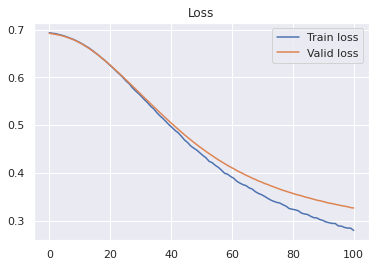

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

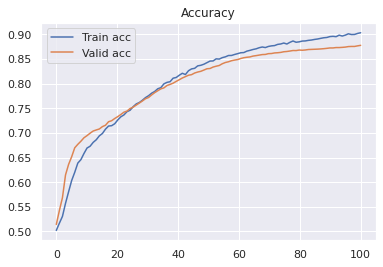

In [14]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

Les hyperparamètres choisis sont : 


|Embedding dim|Learning rate|Dropout|
|-------------|-------------|-------|
|100          | 1e-4       |  0.6  |

## Test

In [15]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.315 | Test Acc: 88.35%


In [17]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    if (prediction.item() > 0.5):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")

In [18]:
predict_sentiment(model, "This film is terrible")

Sentiment: Negative


In [19]:
predict_sentiment(model, "This film is great")

Sentiment: Positive


In [20]:
predict_sentiment(model, "This film is not good")

Sentiment: Negative


## Référence

 - https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb